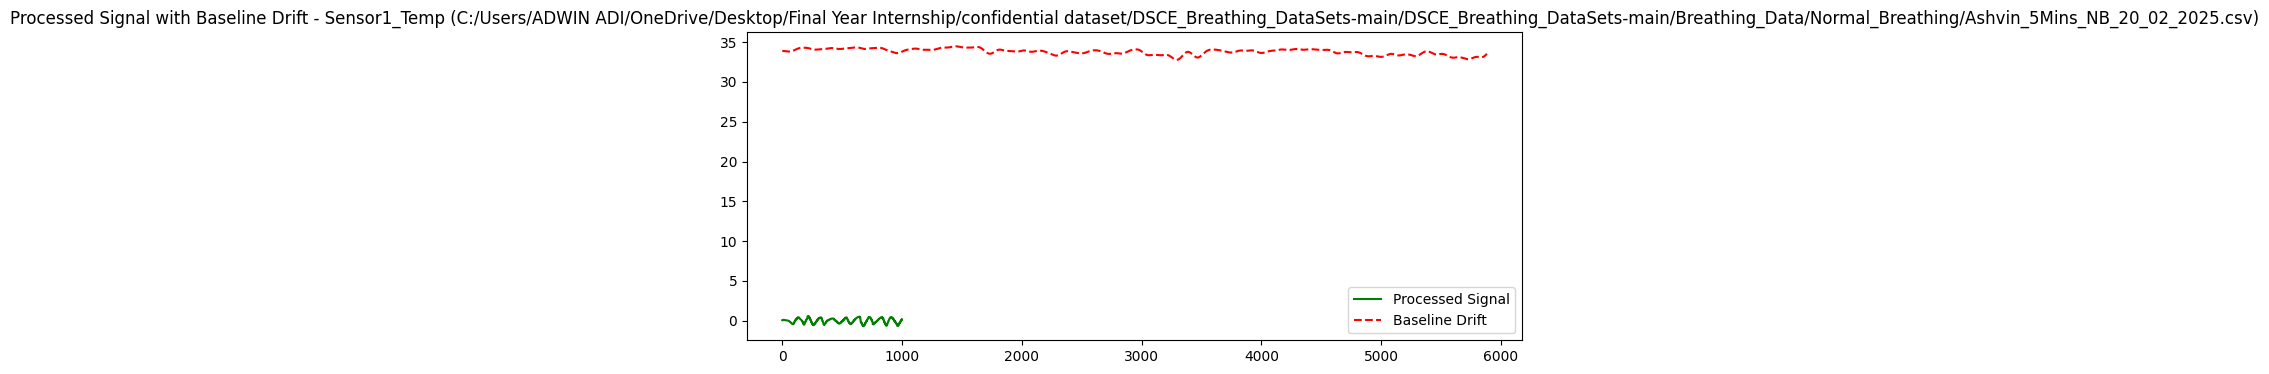

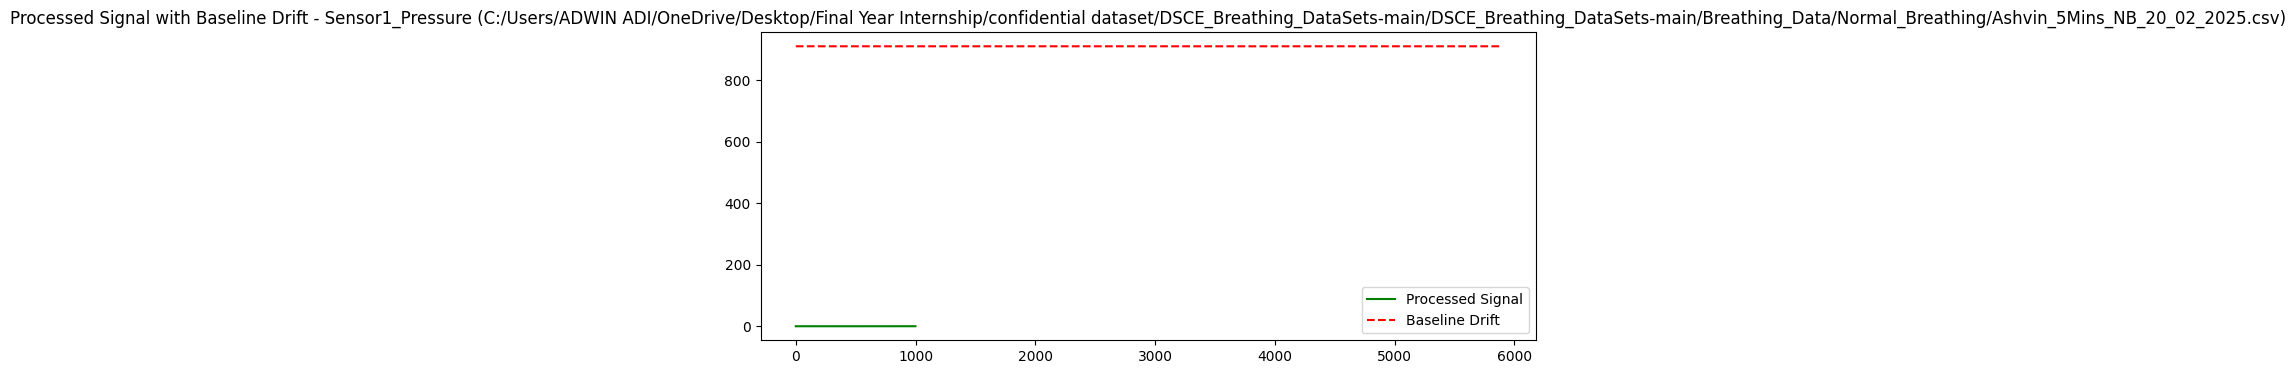

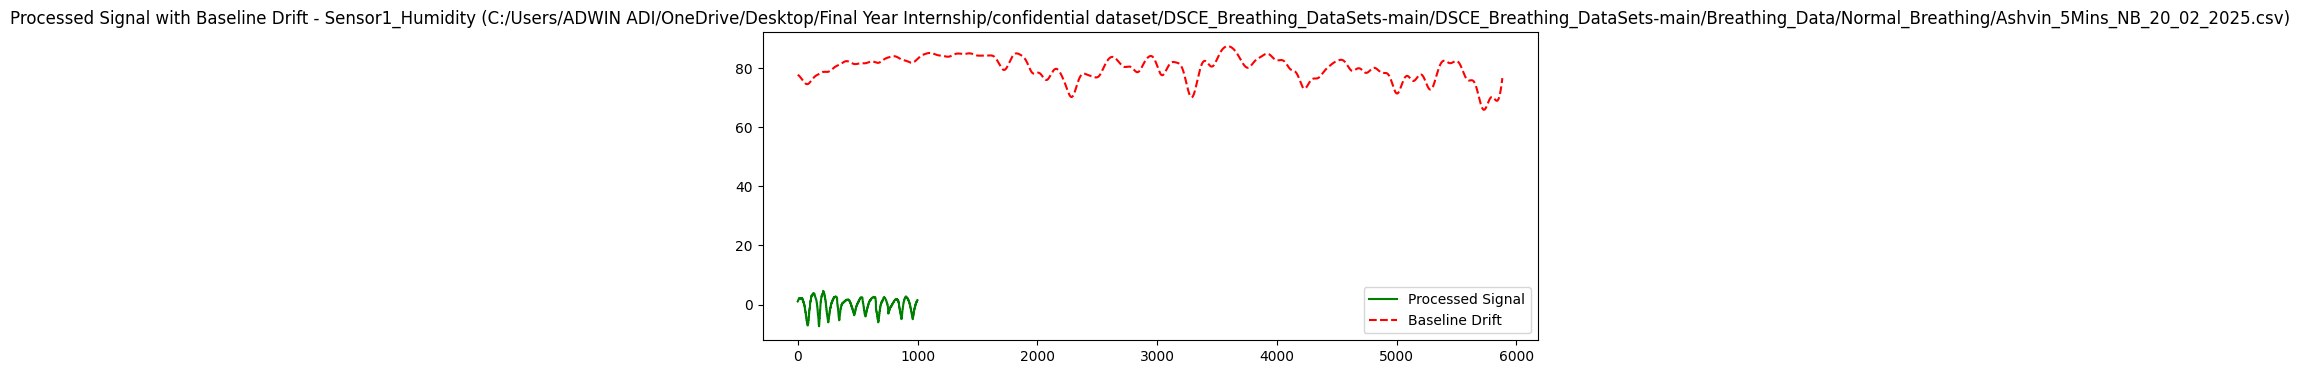

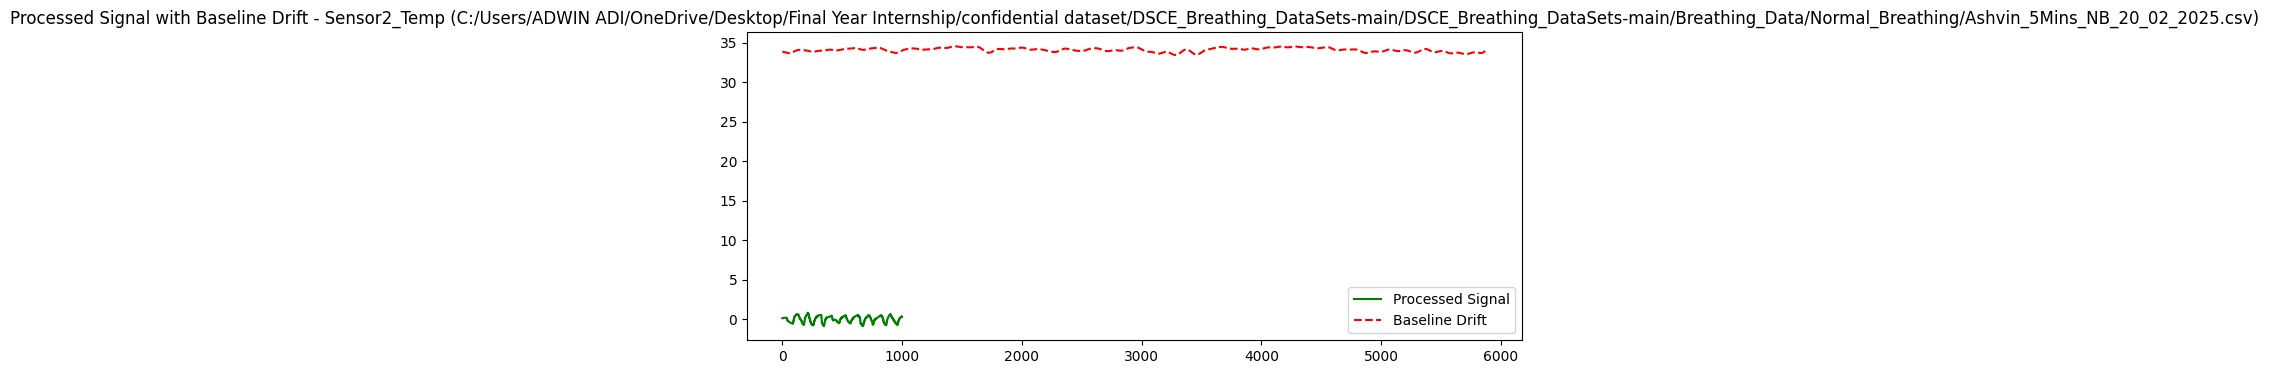

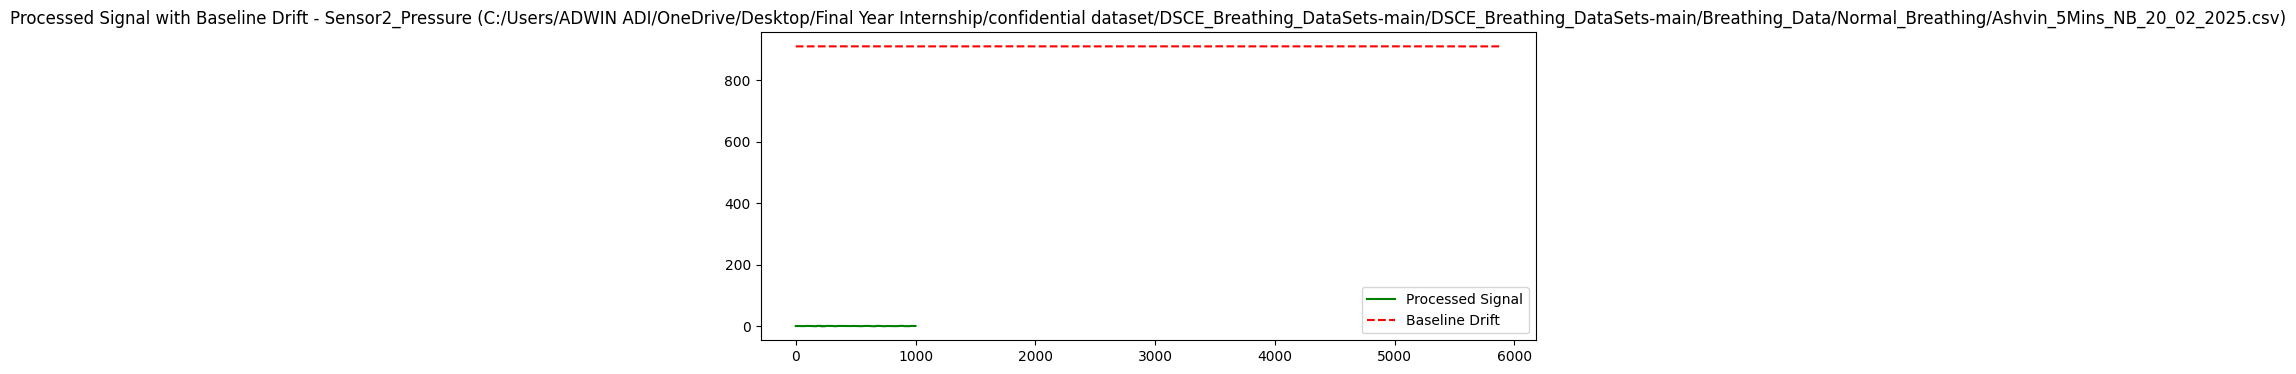

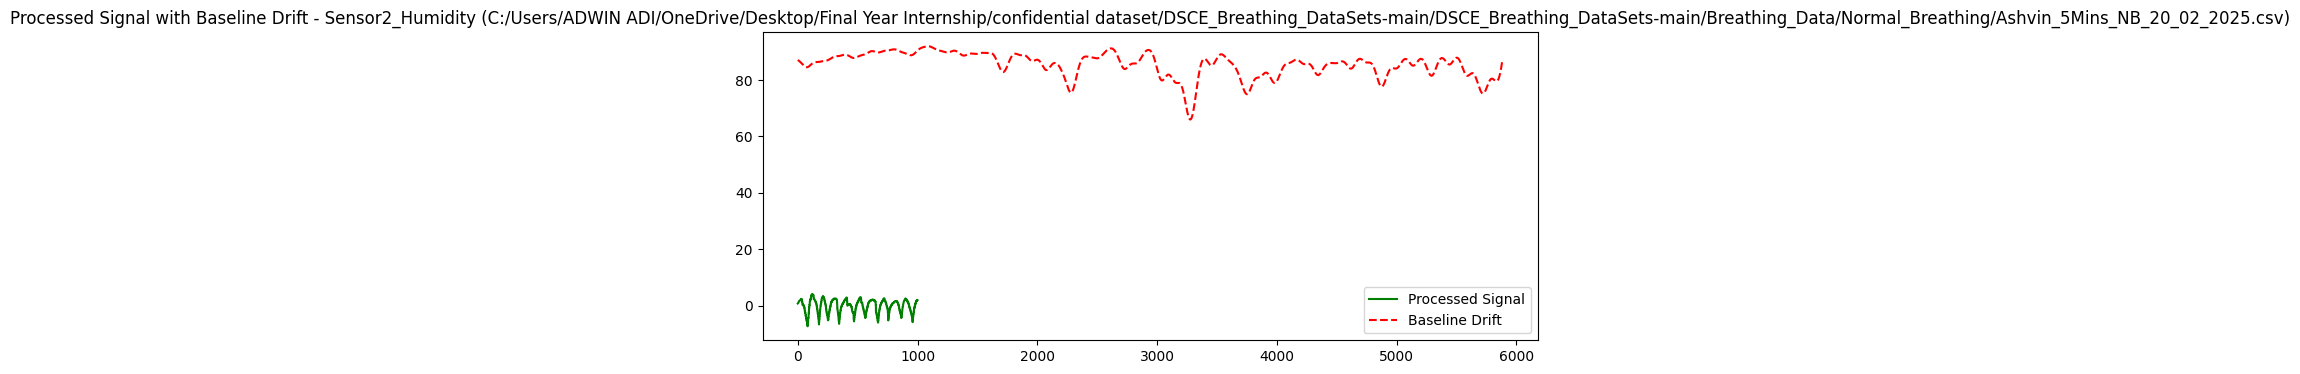


===== Training for 10 epochs on C:/Users/ADWIN ADI/OneDrive/Desktop/Final Year Internship/confidential dataset/DSCE_Breathing_DataSets-main/DSCE_Breathing_DataSets-main/Breathing_Data/Normal_Breathing/Ashvin_5Mins_NB_20_02_2025.csv =====
Epoch 1/10
294/294 [==============================] - 7s 11ms/step - loss: nan - accuracy: 0.9300
Epoch 2/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 3/10
294/294 [==============================] - 3s 11ms/step - loss: nan - accuracy: 0.9308
Epoch 4/10
294/294 [==============================] - 2s 8ms/step - loss: nan - accuracy: 0.9308
Epoch 5/10
294/294 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.9308
Epoch 6/10
294/294 [==============================] - 785s 3s/step - loss: nan - accuracy: 0.9308
Epoch 7/10
294/294 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.9308
Epoch 8/10
294/294 [==============================] - 1s 5ms/step - loss: nan 

ValueError: Input contains NaN.

In [1]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from torch.nn import Transformer

# Function to load files using Tkinter
def load_files():
    root = tk.Tk()
    root.withdraw()
    file_paths = filedialog.askopenfilenames(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
    if not file_paths:
        print("No file selected. Exiting...")
        exit()
    return file_paths

# High-pass filter for baseline wandering removal
def high_pass_filter(signal, fs=100, cutoff=0.5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(2, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

# Outlier removal using Z-score method
def remove_outliers(signal, threshold=3):
    z_scores = zscore(signal)
    return np.where(np.abs(z_scores) > threshold, np.median(signal), signal)

# Function to ensure all signals have exactly 1000 samples
def ensure_1000_samples(df, numeric_columns):
    for col in numeric_columns:
        if len(df[col]) > 1000:
            df[col] = df[col][:1000]  # Trim
        elif len(df[col]) < 1000:
            df[col] = np.pad(df[col], (0, 1000 - len(df[col])), mode='constant')  # Pad
    return df

# Data Preprocessing Function
def preprocess_data(df):
    numeric_columns = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Fill NaN values using interpolation
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
    
    # Detect Baseline Wandering
    baseline_drift = df[numeric_columns].apply(lambda x: x - high_pass_filter(x))
    
    # Remove Baseline Wandering
    df[numeric_columns] = df[numeric_columns].apply(high_pass_filter)
    
    # Detect Outliers
    outliers = df[numeric_columns].apply(lambda x: np.abs(zscore(x)) > 3)
    
    # Remove Outliers
    df[numeric_columns] = df[numeric_columns].apply(remove_outliers)

    # Ensure exactly 1000 samples
    df = ensure_1000_samples(df, numeric_columns)

    return df, numeric_columns, baseline_drift, outliers

# Function to plot signals
def plot_signals(df, numeric_columns, baseline_drift, file_name):
    for col in numeric_columns:
        plt.figure(figsize=(10, 4))
        plt.plot(df[col], label="Processed Signal", color="green")
        plt.plot(baseline_drift[col], label="Baseline Drift", color="red", linestyle="dashed")
        plt.title(f"Processed Signal with Baseline Drift - {col} ({file_name})")
        plt.legend()
        plt.show()

# LSTM Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(50, activation='relu'),
        Dense(input_shape[1], activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads=4, hidden_dim=128, num_layers=2):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])  # Get the last time step
        return self.sigmoid(x)

# Function to Calculate Performance Metrics
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true.flatten(), y_pred_binary.flatten())
    specificity = recall_score(y_true.flatten(), y_pred_binary.flatten(), pos_label=0, zero_division=1)
    f1 = f1_score(y_true.flatten(), y_pred_binary.flatten(), zero_division=1)
    loss = mean_squared_error(y_true.flatten(), y_pred.flatten())  # Correct Loss Calculation
    return accuracy, specificity, f1, loss

# Load and Process Data
file_paths = load_files()
dataframes = [(pd.read_csv(file), file) for file in file_paths]
processed_data = []

for df, file_name in dataframes:
    df, numeric_columns, baseline_drift, _ = preprocess_data(df)
    processed_data.append((df, numeric_columns, baseline_drift, file_name))
    plot_signals(df, numeric_columns, baseline_drift, file_name)

# Training & Performance Evaluation
for df, numeric_columns, _, file_name in processed_data:
    scaler = MinMaxScaler()
    processed_values = scaler.fit_transform(df[numeric_columns])

    X, y = [], []
    seq_length = 10
    for i in range(len(processed_values) - seq_length):
        X.append(processed_values[i:i+seq_length])
        y.append(processed_values[i+seq_length])
    
    X, y = np.array(X), np.array(y)
    y = (y > 0.5).astype(int)  

    train_size = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    performance_data = []
    epochs_list = [10, 30, 50, 75, 100]

    for num_epochs in epochs_list:
        print(f"\n===== Training for {num_epochs} epochs on {file_name} =====")
        lstm_model = build_lstm_model((seq_length, len(numeric_columns)))
        lstm_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, verbose=1)
        y_pred_lstm = lstm_model.predict(X_test)
        lstm_acc, lstm_spec, lstm_f1, lstm_loss = calculate_metrics(y_test, y_pred_lstm)
        performance_data.append([num_epochs, lstm_loss, lstm_acc, lstm_spec, lstm_f1])

    performance_df = pd.DataFrame(performance_data, columns=["Epochs", "LSTM Loss", "LSTM Accuracy", "LSTM Specificity", "LSTM F1 Score"])
    print(performance_df)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs_list, performance_df["LSTM Accuracy"], marker='o', label=f"LSTM Accuracy ({file_name})", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
